In [1]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [2]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico122x106x39.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [3]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [4]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [5]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [6]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [7]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 0.8429704


In [8]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [9]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.698  0.331E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     2  -1.562  0.371E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     3  -1.900  0.386E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     4  -2.154  0.183E+00   505392    10.87  0.170   [Radiance 0.660 micron]
     5  -2.466  0.101E+00   510996    11.43  0.179   [Radiance 0.660 micron]
     6  -2.587  0.576E-01   526872    12.88  0.201   [Radiance 0.660 micron]
     7  -2.684  0.394E-01   549449    14.81  0.231   [Radiance 0.660 micron]
     8  -2.765  0.301E-01   576548    16.94  0.265   [Radiance 0.660 micron]
     9  -3.086  0.300E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    10  -3.415  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    11  -3.638  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    12  -3.787  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
  

In [10]:
%%time
grads_iter1 = []
def retrieve():
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', 6121208040.160534)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = 100.54800690534589 * 3943.0 / 15905.0
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        grads_iter1.append(np.nanmean(full_grad))
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), solvers_reconstruct, optimizer

CPU times: user 7 μs, sys: 2 μs, total: 9 μs
Wall time: 14.1 μs


In [11]:
for i in range(200):
    print(str(i) + "/200")
    max_reff, solvers_reconstruct, optimizer = retrieve()
    if max_reff > 19.5:
        break
py.hist(np.log(np.abs(grads_iter1)), bins=20)
py.xlabel("log(abs(mean(gradient)))")
py.ylabel("frequency after 1 iteration")

0/200
0.52 1.72


<timed exec>:36: RuntimeWarning: Mean of empty slice


[249.26802341  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 385.37348473541124
cloud density avg. 10.0 -2.35552261901861
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 4.603417859563406 -61.02190944167869
cloud density avg. 13.538479993989677 0.0261907543788927
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.12595573 4.2009895  4.27343459 4.34350334 4.41138155 4.47723277
 4.54120188 4.60341786 4.66399609 4.72304029 4.78064402 4.83689205
 4.89186144 4.94562246 4.99823941 5.04977129 5.10027235 5.14979266
 5.19837847 5.24607268 5.2929151 ]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    7    f=  1.39205D+04    |proj g|=  6.10219D+01
reff 11.18084422399263 117.3300430506826
cloud density avg. 13.388208180090277 -0.49469577375691154
reff 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 0.30610894482644063 38.518343960804685
cloud density avg. 13.273634363031354 -0.03868338237217638
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   14    f=  3.71434D+03    |proj g|=  7.62782D+00
reff 0.0001 6.250540427053654
cloud density avg. 13.378926070851708 -0.001642027553457696
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 0.9277115632978444 -10.670365472144066
cloud density avg. 13.438334832366968 0.014227498772090473
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   19    f=  2.51449D+03    |proj g|=  1.06704D+01
reff 2.1435831989523795 4.034177827581713
cloud density avg. 13.397920596771652 -0.0035305541989644426
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.1

<timed exec>:36: RuntimeWarning: Mean of empty slice


[249.26802341  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 385.37348473541124
cloud density avg. 10.0 -2.35552261901861
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  1

KeyboardInterrupt: 

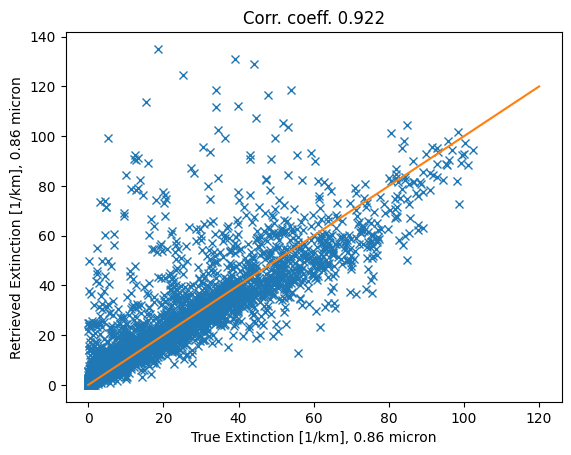

In [ ]:
def plot_extinction():   
    #compare cell averaged extinction on the TRUE grid.
    true_geo_extinct = list(solvers.values())[0].medium['cloud']
    true_geo_extinct.extinction.data = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)

    reference, other = at3d.util.cell_average_comparison(
        true_geo_extinct,
                                    list(solvers_reconstruct.values())[0].medium['cloud'],
                                    'extinction')
    py.figure()
    py.plot(reference.ravel(),
            other.ravel(),'x')
    py.plot([0, 120.0], [0.0, 120.0])
    py.xlabel('True Extinction [1/km], 0.86 micron')
    py.ylabel('Retrieved Extinction [1/km], 0.86 micron')
    py.title('Corr. coeff. %.3f'%np.corrcoef(reference.ravel(), other.ravel())[1, 0])
    return reference, other
reference, other = plot_extinction()

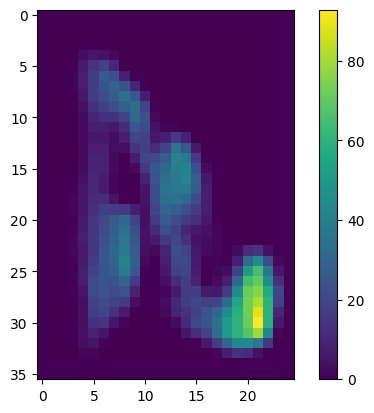

In [ ]:
py.figure()
py.imshow(other[12])
py.colorbar()

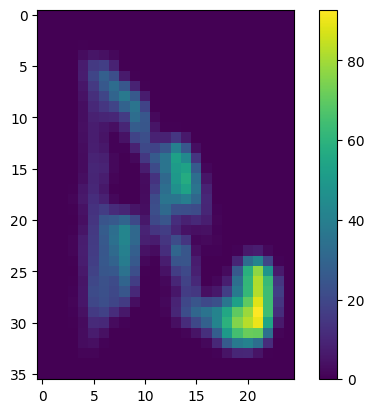

In [ ]:
py.figure()
py.imshow(reference[12])
py.colorbar()

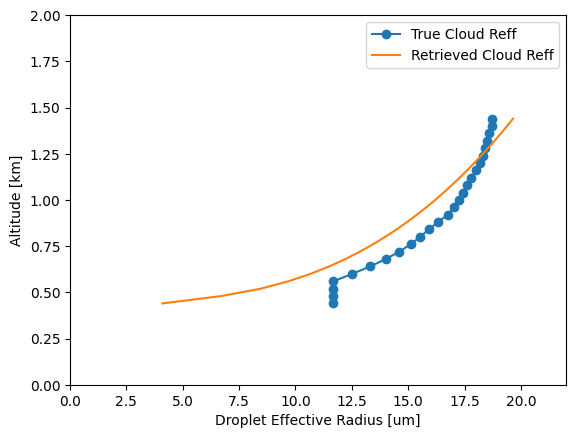

In [ ]:
def plot_reff():    
    #plot Reff profiles.
    #remake the true grid since it was overwritten.
    rte_grid2 = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                            cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                            cloud_scatterer.z)

    py.figure()
    py.plot(solvers[0.66].medium['cloud'].reff[16,16], rte_grid.z, marker='o', label = 'True Cloud Reff')
    py.plot(solvers_reconstruct[0.66].medium['cloud'].reff[16,16], rte_grid2.z, label='Retrieved Cloud Reff')
    py.legend()
    py.xlabel('Droplet Effective Radius [um]')
    py.ylabel('Altitude [km]')
    #py.fill_between([0,23], CBH, CTH, color='0.9')
    py.ylim(0, 2.)
    py.xlim(0, 22)
plot_reff()

(0.0, 2.0)

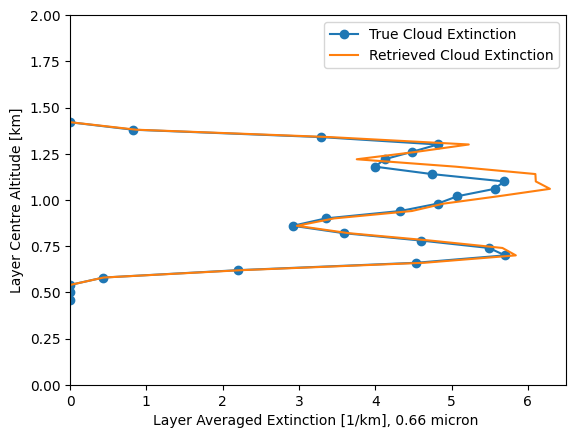

In [ ]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
#py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.66 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

reff 19.651369969168705 -2.1375984829054477
cloud density avg. 25.475674857238253 0.15707533598378348
reff profile retrieve [ 4.1         6.72067399  8.46751863  9.69288918 10.66840497 11.49219087
 12.21227511 12.85618685 13.44134799 13.97956525 14.47925319 14.94664516
 15.38650248 15.80255389 16.19778044 16.57460735 16.93503727 17.28074532
 17.61314853 17.93345756 18.24271588 18.54182996 18.83159286 19.11270285
 19.38577836 19.65136997]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0        82 variables are exactly at the bounds

At iterate    0    f=  3.60780D+04    |proj g|=  8.99211D+00
reff 19.67262945057163 -0.8420584812733373
cloud density avg. 25.323103858546 -0.0911110512870746
reff profile retrieve [ 4.1

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.008490800857544'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -2.0939521895105666
cloud density avg. 26.69719104405374 -0.7283089748002634
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 23.62459873110297 -2.0430362559489077
cloud density avg. 25.568759627886532 0.20016905006931326
reff profile retrieve [ 4.1         8.07949912 10.17953101 11.65265413 12.8254054  13.81574915
 14.68142422 15.4555258  16.15899823 16.80603541 17.40675317 17.96864518
 18.49743542 18.99760653 19.47274229 19.92575827 20.35906202 20.77466734
 21.17427778 2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 1.752275603681691
cloud density avg. 24.96486703495919 -0.5167645870117263
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 23.624598731102974 0.684689807802946
cloud density avg. 24.991318291521686 -0.19797591082582736
reff profile retrieve [ 4.1         8.07949912 10.17953101 11.65265413 12.8254054  13.81574915
 14.68142422 15.4555258  16.15899823 16.80603541 17.40675317 17.96864518
 18.49743542 18.99760653 19.47274229 19.92575827 20.35906202 20.77466734
 21.17427778 21.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


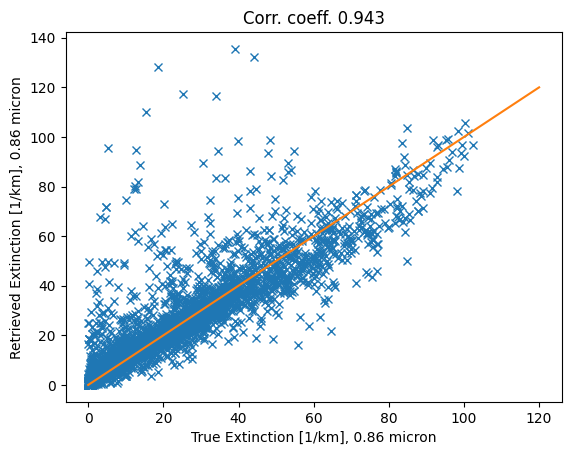

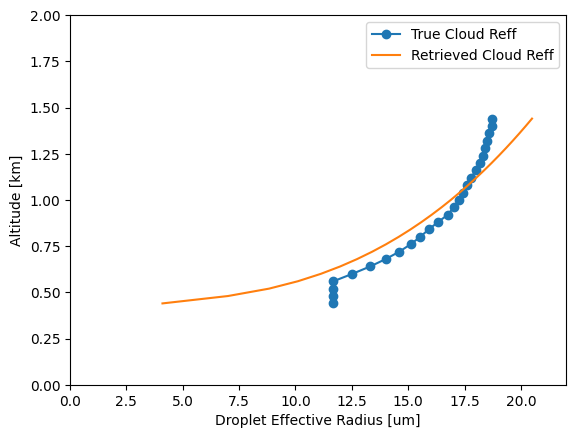

In [ ]:
optimizer._options['maxiter'] = 50
result = optimizer.minimize(optimizer._state)
plot_extinction()
plot_reff()

(0.0, 2.0)

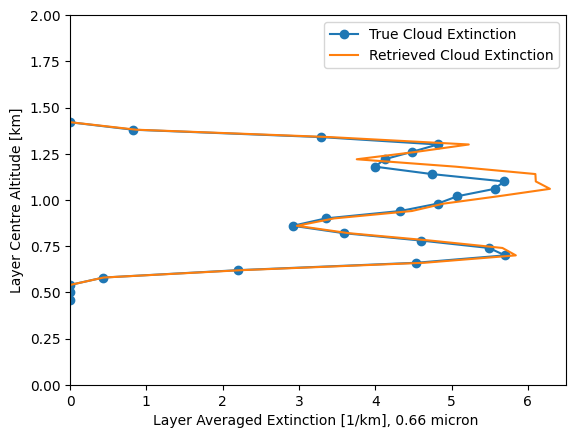

In [ ]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
#py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.66 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

In [ ]:
0/200
0.52 1.72
<timed exec>:36: RuntimeWarning: Mean of empty slice
[4055.8357845   10.          10.        ...   10.          10.
   10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 23.684708138394168
cloud density avg. 10.0 -2.35552261901861
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15906     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86934D+05    |proj g|=  2.36847D+01
reff 9.941603384858698 14.476108159784895
cloud density avg. 12.355522619018611 -0.7723666781297314
reff profile retrieve [ 4.1         4.1         4.28370704  4.90362046  5.39713267  5.81388493
  6.17817464  6.50392878  6.79996106  7.0722445   7.325036    7.56148901
  7.78401228  7.99449216  8.19443678  8.38507304  8.56741408  8.74230735
  8.91046972  9.07251366  9.22896705  9.38028849  9.52687917  9.66909237
  9.80724092  9.94160338 10.07242896 10.1999416  10.32434339 10.4458174
 10.56453003 10.68063306 10.79426535 10.90555428 11.01461706 11.12156177
 11.22648836 11.32948942 11.43065093]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    1    f=  3.24664D+05    |proj g|=  1.44761D+01
reff 9.861054230521756 6.743811284135314
cloud density avg. 13.746537692165766 -0.17248443182658477
reff profile retrieve [ 4.1         4.1         4.24899946  4.8638902   5.35340386  5.7667795
  6.12811765  6.45123246  6.74486622  7.01494355  7.26568688  7.50022409
  7.72094442  7.92971895  8.12804357  8.31713525  8.49799893  8.67147517
  8.83827505  8.99900607  9.15419184  9.30428724  9.44969021  9.59075116
  9.7277804   9.86105423  9.99081983 10.11729933 10.24069319 10.36118298
 10.47893378 10.59409612 10.70680773 10.81719497 10.9253741  11.03145232
 11.13552878 11.2376953  11.33803717]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    2    f=  1.03447D+05    |proj g|=  6.74381D+00
reff 9.790103894323005 3.5258320147862756
cloud density avg. 14.226990597019922 -0.1186625434947888
reff profile retrieve [ 4.1         4.1         4.21842789  4.82889449  5.3148861   5.72528749
  6.08402581  6.4048158   6.69633687  6.964471    7.21341022  7.44625994
  7.66539219  7.87266458  8.06956225  8.25729342  8.43685578  8.60908386
  8.77468361  8.93425817  9.08832738  9.23734284  9.38169964  9.52174566
  9.65778897  9.79010389  9.91893582 10.0445053  10.16701135 10.28663422
 10.4035378  10.51787154 10.62977219 10.7393652  10.84676597 10.95208097
 11.05540859 11.15684002 11.25645994]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    3    f=  3.69133D+04    |proj g|=  3.92887D+00
reff 9.713302468801508 -0.6828463087050715
cloud density avg. 14.992480560380763 0.06159468121815906
reff profile retrieve [ 4.1         4.1         4.18533516  4.79101277  5.27319187  5.68037374
  6.03629783  6.35457129  6.64380543  6.9098361   7.15682245  7.38784551
  7.6052587   7.81090509  8.00625814  8.19251659  8.37067032  8.5415473
  8.70584796  8.86417069  9.01703126  9.16487772  9.30810207  9.44704945
  9.58202553  9.71330247  9.84112374  9.96570815 10.08725316 10.20593761
 10.3219241  10.43536092 10.54638373 10.65511701 10.76167524 10.86616406
 10.9686811  11.06931682 11.16815524]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    4    f=  1.50021D+04    |proj g|=  3.47174D+00
reff 9.697380095396882 -0.1368604887327458
cloud density avg. 15.015002050816355 -0.0025366445332167748
reff profile retrieve [ 4.1         4.1         4.17847442  4.78315918  5.26454787  5.67106228
  6.02640293  6.34415467  6.63291468  6.89850927  7.14509075  7.3757351
  7.59279191  7.79810119  7.99313401  8.17908714  8.35694883  8.52754571
  8.69157704  8.84964024  9.00225023  9.14985434  9.29284391  9.43156352
  9.56631835  9.6973801   9.82499184  9.94937203 10.07071779 10.18920769
 10.30500406 10.41825493 10.52909575 10.63765078 10.74403434 10.84835188
 10.95070087 11.05117162 11.14984802]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    5    f=  9.24147D+03    |proj g|=  2.27959D+00
reff 9.685853170501092 -0.3773170035418241
cloud density avg. 15.118495795557424 0.018517808638192124
reff profile retrieve [ 4.1         4.1         4.17350761  4.77747361  5.2582901   5.6643213
  6.01923956  6.3366136   6.62503038  6.89030926  7.13659763  7.36696783
  7.58376663  7.78883187  7.98363286  8.16936496  8.34701523  8.51740932
  8.68124567  8.83912099  8.99154958  9.13897824  9.28179784  9.42035257
  9.55494722  9.68585317  9.81331322  9.93754557 10.05874709 10.17709615
 10.29275487 10.40587113 10.51658019 10.62500619 10.7312633  10.83545684
 10.93768416 11.0380355  11.1365946 ]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    6    f=  6.00324D+03    |proj g|=  3.01767D+00
reff 9.684046779492844 0.026287993032942776
cloud density avg. 15.088923508170828 -0.0064894523385622006
reff profile retrieve [ 4.1         4.1         4.17272926  4.77658262  5.25730944  5.66326491
  6.01811699  6.33543183  6.62379482  6.88902423  7.13526667  7.36559391
  7.58235227  7.78737927  7.98214393  8.16784139  8.34545853  8.51582085
  8.67962664  8.83747251  8.98987268  9.13727384  9.28006681  9.41859569
  9.55316524  9.68404678  9.81148306  9.93569224 10.05687116 10.17519814
 10.29083529 10.40393045 10.51461887 10.62302465 10.72926194 10.83343605
 10.93564431 11.03597693 11.13451765]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    7    f=  4.68084D+03    |proj g|=  2.69755D+00
reff 9.685407218766894 0.11422421582718163
cloud density avg. 15.075251137600581 -0.00429627827246582
reff profile retrieve [ 4.1         4.1         4.17331546  4.77725365  5.258048    5.6640605
  6.01896243  6.33632185  6.62472535  6.88999202  7.13626905  7.36662864
  7.58341746  7.78847326  7.98326528  8.16898883  8.34663092  8.51701717
  8.68084598  8.83871402  8.9911356   9.13855747  9.28137049  9.41991884
  9.55450729  9.68540722  9.8128614   9.93708803 10.05828397 10.17662758
 10.29228098 10.40539202 10.51609599 10.624517   10.73076921 10.83495796
 10.93718058 11.03752729 11.13608185]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    8    f=  3.77992D+03    |proj g|=  1.81476D+00
reff 9.686404117187518 0.17332726436793433
cloud density avg. 15.063060751340641 -0.00653254992443599
reff profile retrieve [ 4.1         4.1         4.17374501  4.77774536  5.2585892   5.66464349
  6.01958195  6.33697403  6.62540722  6.89070119  7.13700358  7.36738687
  7.58419801  7.78927491  7.98408698  8.16982964  8.34749002  8.51789381
  8.68173948  8.83962377  8.99206104  9.13949808  9.28232581  9.42088841
  9.55549072  9.68640412  9.81387142  9.93811083 10.05931925 10.17767504
 10.29334034 10.40646303 10.51717839 10.62561055 10.73187371 10.83607317
 10.93830632 11.03866336 11.13722807]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    9    f=  2.86743D+03    |proj g|=  1.23609D+00
reff 9.68462738764599 0.06552262751622963
cloud density avg. 15.088805277749593 -0.0032046777455707336
reff profile retrieve [ 4.1         4.1         4.17297944  4.776869    5.25762464  5.66360445
  6.01847781  6.33581167  6.62419195  6.88943726  7.13569447  7.36603551
  7.58280688  7.78784616  7.9826225   8.16833109  8.34595888  8.51633141
  8.68014703  8.83800237  8.99041167  9.13782167  9.28062319  9.41916038
  9.553738    9.68462739  9.81207131  9.93628793 10.05747412 10.1758082
 10.29145228 10.40455422 10.51524928 10.62366155 10.72990521 10.83408557
 10.93629996 11.03663859 11.13518522]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   10    f=  2.27943D+03    |proj g|=  2.42533D+00
reff 9.681901605416552 -0.10417614247925204
cloud density avg. 15.131715467191958 0.004013788983201215
reff profile retrieve [ 4.1         4.1         4.17180494  4.77552453  5.25614486  5.66201041
  6.01678388  6.33402843  6.62232755  6.8874982   7.1336861   7.36396231
  7.58067266  7.78565424  7.98037575  8.16603208  8.34360987  8.51393445
  8.67770396  8.83551487  8.98788128  9.13524978  9.27801112  9.41650932
  9.55104906  9.68190161  9.80930966  9.93349132 10.0546434  10.17294417
 10.28855571 10.40162581 10.51228971 10.62067147 10.72688523 10.83103626
 10.93322189 11.03353228 11.13205117]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   11    f=  1.86117D+03    |proj g|=  1.15887D+00
reff 9.680586014408433 -0.14224363931698844
cloud density avg. 15.161879830679723 0.002149013474405322
reff profile retrieve [ 4.1         4.1         4.17123807  4.77487562  5.25543064  5.66124104
  6.01596631  6.33316775  6.62142769  6.88656232  7.13271676  7.36296168
  7.57964259  7.78459631  7.97929137  8.16492246  8.34247613  8.51277757
  8.67652482  8.83431429  8.98665999  9.13400847  9.27675041  9.41522979
  9.54975125  9.68058601  9.80797675  9.93214154 10.05327716 10.17156186
 10.28715768 10.40021242 10.51086129 10.61922832 10.72542765 10.82956453
 10.93173626 11.03203303 11.13053853]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   12    f=  1.51440D+03    |proj g|=  1.50639D+00
reff 9.681771184450135 -0.17091144374343362
cloud density avg. 15.179486469897864 0.004113372673279236
reff profile retrieve [ 4.1         4.1         4.17174874  4.7754602   5.25607405  5.66193414
  6.01670283  6.33394311  6.62223834  6.88740542  7.13359     7.36386311
  7.58057054  7.78554936  7.98026825  8.16592207  8.34349748  8.51381976
  8.67758707  8.83539585  8.9877602   9.13512673  9.27788614  9.41638247
  9.5509204   9.68177118  9.80917752  9.93335751 10.05450795 10.17280714
 10.28841711 10.4014857  10.51214811 10.62052841 10.72674074 10.83089036
 10.93307461 11.03338365 11.13190122]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   13    f=  1.25440D+03    |proj g|=  5.85679D-01
reff 9.686289993601667 -0.04898231144863543
cloud density avg. 15.17116166492341 -0.0026557110336805955
reff profile retrieve [ 4.1         4.1         4.17369584  4.77768907  5.25852724  5.66457675
  6.01951103  6.33689937  6.62532916  6.89062     7.13691949  7.36730007
  7.58410865  7.78918314  7.98399291  8.16973339  8.34739167  8.51779345
  8.68163719  8.83951963  8.99195509  9.1393904   9.28221644  9.42077742
  9.55537814  9.68628999  9.8137558   9.93799374 10.05920073 10.17755513
 10.29321907 10.40634042 10.51705448 10.62548537 10.73174727 10.83594551
 10.93817744 11.0385333  11.13709685]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   14    f=  9.69617D+02    |proj g|=  8.65310D-01
reff 9.691529717515092 -0.10702983590270461
cloud density avg. 15.184253892899342 0.0062187809388777075
reff profile retrieve [ 4.1         4.1         4.17595356  4.78027352  5.2613718   5.66764096
  6.02276723  6.34032727  6.62891308  6.89434743  7.14078015  7.37128536
  7.58821122  7.79339664  7.98831179  8.17415274  8.35190713  8.52240109
  8.68633346  8.8443013   8.99681922  9.14433428  9.28723759  9.42587351
  9.56054704  9.69152972  9.81906447  9.94336962 10.06464218 10.1830606
 10.2987871  10.41196965 10.5227436  10.63123314 10.73755252 10.84180713
 10.94409437 11.04450451 11.14312138]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   15    f=  7.87565D+02    |proj g|=  1.73536D+00
reff 9.693039560037203 -0.051591064702153536
cloud density avg. 15.172201599741165 0.0031623304056987546
reff profile retrieve [ 4.1         4.1         4.17660414  4.78101824  5.26219147  5.66852392
  6.02370552  6.34131503  6.6299458   6.8954215   7.14189261  7.37243373
  7.58939338  7.79461077  7.98955629  8.17542619  8.35320827  8.52372879
  8.6876867   8.84567915  8.99822084  9.14575888  9.28868444  9.42734197
  9.56203648  9.69303956  9.82059418  9.9449187  10.06621015 10.18464702
 10.30039155 10.41359173 10.52438294 10.63288938 10.73922533 10.84349617
 10.94579935 11.04622513 11.14485736]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   16    f=  6.74550D+02    |proj g|=  4.39959D-01
reff 9.694196149655744 -0.007044800530372095
cloud density avg. 15.162790573661079 -0.0010779890013580386
reff profile retrieve [ 4.1         4.1         4.1771025   4.78158872  5.26281936  5.6692003
  6.02442428  6.34207169  6.6307369   6.89624428  7.14274479  7.37331342
  7.59029896  7.79554083  7.99050962  8.1764017   8.35420499  8.52474586
  8.68872333  8.84673463  8.99929452  9.14685016  9.28979279  9.42846685
  9.56317744  9.69419615  9.82176599  9.94610534 10.06741127 10.18586227
 10.30162061 10.4148343  10.52563872 10.63415811 10.74050675 10.84479003
 10.94710542 11.04754319 11.14618719]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   17    f=  6.02464D+02    |proj g|=  4.01294D-01
reff 9.695697125647415 -0.028560533729526053
cloud density avg. 15.169459572566096 -0.000223904690012649
reff profile retrieve [ 4.1         4.1         4.17774925  4.78232906  5.26363422  5.67007808
  6.02535706  6.34305364  6.63176355  6.89731204  7.14385072  7.37445505
  7.59147419  7.79674784  7.99174681  8.17766767  8.35549849  8.52606576
  8.69006862  8.84810439  9.0006879   9.14826639  9.29123115  9.42992669
  9.56465813  9.69569713  9.82328672  9.94764532 10.06897003 10.18743937
 10.30321563 10.41644685 10.52726843 10.63580463 10.74216973 10.84646916
 10.94880038 11.04925371 11.14791298]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   18    f=  5.25647D+02    |proj g|=  6.50340D-01
reff 9.6996796621662 0.030767383627588792
cloud density avg. 15.168815858163558 -0.009539185387285492
reff profile retrieve [ 4.1         4.1         4.17946527  4.78429342  5.26579627  5.67240708
  6.02783199  6.34565907  6.63448757  6.90014513  7.14678508  7.37748413
  7.59459241  7.79995037  7.99502944  8.18102667  8.35893054  8.52956787
  8.6936381   8.85173878  9.00438496  9.15202407  9.29504755  9.43380006
  9.56858684  9.69967966  9.82732166  9.95173135 10.07310589 10.19162389
 10.30744771 10.42072544 10.53159254 10.64017331 10.74658211 10.85092438
 10.95329764 11.05379222 11.15249202]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   19    f=  4.80237D+02    |proj g|=  9.40911D-01
reff 9.699957062891066 -0.053997559756787696
cloud density avg. 15.187660951463197 -0.0010432139102187522
reff profile retrieve [ 4.1         4.1         4.1795848   4.78443025  5.26594687  5.6725693
  6.02800438  6.34584055  6.6346773   6.90034247  7.14698947  7.37769512
  7.59480961  7.80017344  7.99525809  8.18126064  8.3591696   8.52981181
  8.69388672  8.85199193  9.00464248  9.15228581  9.29531338  9.43406985
  9.56886049  9.69995706  9.82760271  9.95201596 10.07339397 10.19191536
 10.30774249 10.42102346 10.53189373 10.64047761 10.74688945 10.8512347
 10.95361089 11.05410835 11.15281096]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   20    f=  4.24696D+02    |proj g|=  2.19049D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15906     20     21    362     0   103   2.190D-01   4.247D+02
  F =   424.69612041065994     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
1/200
0.52 1.72
<timed exec>:36: RuntimeWarning: Mean of empty slice
[4055.8357845   10.          10.        ...   10.          10.
   10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 23.684708138394168
cloud density avg. 10.0 -2.35552261901861
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15906     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86934D+05    |proj g|=  2.36847D+01
reff 9.941603384858698 14.476108159784895
cloud density avg. 12.355522619018611 -0.7723666781297314
reff profile retrieve [ 4.1         4.1         4.28370704  4.90362046  5.39713267  5.81388493
  6.17817464  6.50392878  6.79996106  7.0722445   7.325036    7.56148901
  7.78401228  7.99449216  8.19443678  8.38507304  8.56741408  8.74230735
  8.91046972  9.07251366  9.22896705  9.38028849  9.52687917  9.66909237
  9.80724092  9.94160338 10.07242896 10.1999416  10.32434339 10.4458174
 10.56453003 10.68063306 10.79426535 10.90555428 11.01461706 11.12156177
 11.22648836 11.32948942 11.43065093]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    1    f=  3.24664D+05    |proj g|=  1.44761D+01
reff 9.861054230521756 6.743811284135314
cloud density avg. 13.746537692165766 -0.17248443182658477
reff profile retrieve [ 4.1         4.1         4.24899946  4.8638902   5.35340386  5.7667795
  6.12811765  6.45123246  6.74486622  7.01494355  7.26568688  7.50022409
  7.72094442  7.92971895  8.12804357  8.31713525  8.49799893  8.67147517
  8.83827505  8.99900607  9.15419184  9.30428724  9.44969021  9.59075116
  9.7277804   9.86105423  9.99081983 10.11729933 10.24069319 10.36118298
 10.47893378 10.59409612 10.70680773 10.81719497 10.9253741  11.03145232
 11.13552878 11.2376953  11.33803717]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    2    f=  1.03447D+05    |proj g|=  6.74381D+00
reff 9.790103894323005 3.5258320147862756
cloud density avg. 14.226990597019922 -0.1186625434947888
reff profile retrieve [ 4.1         4.1         4.21842789  4.82889449  5.3148861   5.72528749
  6.08402581  6.4048158   6.69633687  6.964471    7.21341022  7.44625994
  7.66539219  7.87266458  8.06956225  8.25729342  8.43685578  8.60908386
  8.77468361  8.93425817  9.08832738  9.23734284  9.38169964  9.52174566
  9.65778897  9.79010389  9.91893582 10.0445053  10.16701135 10.28663422
 10.4035378  10.51787154 10.62977219 10.7393652  10.84676597 10.95208097
 11.05540859 11.15684002 11.25645994]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    3    f=  3.69133D+04    |proj g|=  3.92887D+00
reff 9.713302468801508 -0.6828463087050715
cloud density avg. 14.992480560380763 0.06159468121815906
reff profile retrieve [ 4.1         4.1         4.18533516  4.79101277  5.27319187  5.68037374
  6.03629783  6.35457129  6.64380543  6.9098361   7.15682245  7.38784551
  7.6052587   7.81090509  8.00625814  8.19251659  8.37067032  8.5415473
  8.70584796  8.86417069  9.01703126  9.16487772  9.30810207  9.44704945
  9.58202553  9.71330247  9.84112374  9.96570815 10.08725316 10.20593761
 10.3219241  10.43536092 10.54638373 10.65511701 10.76167524 10.86616406
 10.9686811  11.06931682 11.16815524]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    4    f=  1.50021D+04    |proj g|=  3.47174D+00
reff 9.697380095396882 -0.1368604887327458
cloud density avg. 15.015002050816355 -0.0025366445332167748
reff profile retrieve [ 4.1         4.1         4.17847442  4.78315918  5.26454787  5.67106228
  6.02640293  6.34415467  6.63291468  6.89850927  7.14509075  7.3757351
  7.59279191  7.79810119  7.99313401  8.17908714  8.35694883  8.52754571
  8.69157704  8.84964024  9.00225023  9.14985434  9.29284391  9.43156352
  9.56631835  9.6973801   9.82499184  9.94937203 10.07071779 10.18920769
 10.30500406 10.41825493 10.52909575 10.63765078 10.74403434 10.84835188
 10.95070087 11.05117162 11.14984802]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    5    f=  9.24147D+03    |proj g|=  2.27959D+00
reff 9.685853170501092 -0.3773170035418241
cloud density avg. 15.118495795557424 0.018517808638192124
reff profile retrieve [ 4.1         4.1         4.17350761  4.77747361  5.2582901   5.6643213
  6.01923956  6.3366136   6.62503038  6.89030926  7.13659763  7.36696783
  7.58376663  7.78883187  7.98363286  8.16936496  8.34701523  8.51740932
  8.68124567  8.83912099  8.99154958  9.13897824  9.28179784  9.42035257
  9.55494722  9.68585317  9.81331322  9.93754557 10.05874709 10.17709615
 10.29275487 10.40587113 10.51658019 10.62500619 10.7312633  10.83545684
 10.93768416 11.0380355  11.1365946 ]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    6    f=  6.00324D+03    |proj g|=  3.01767D+00
reff 9.684046779492844 0.026287993032942776
cloud density avg. 15.088923508170828 -0.0064894523385622006
reff profile retrieve [ 4.1         4.1         4.17272926  4.77658262  5.25730944  5.66326491
  6.01811699  6.33543183  6.62379482  6.88902423  7.13526667  7.36559391
  7.58235227  7.78737927  7.98214393  8.16784139  8.34545853  8.51582085
  8.67962664  8.83747251  8.98987268  9.13727384  9.28006681  9.41859569
  9.55316524  9.68404678  9.81148306  9.93569224 10.05687116 10.17519814
 10.29083529 10.40393045 10.51461887 10.62302465 10.72926194 10.83343605
 10.93564431 11.03597693 11.13451765]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    7    f=  4.68084D+03    |proj g|=  2.69755D+00
reff 9.685407218766894 0.11422421582718163
cloud density avg. 15.075251137600581 -0.00429627827246582
reff profile retrieve [ 4.1         4.1         4.17331546  4.77725365  5.258048    5.6640605
  6.01896243  6.33632185  6.62472535  6.88999202  7.13626905  7.36662864
  7.58341746  7.78847326  7.98326528  8.16898883  8.34663092  8.51701717
  8.68084598  8.83871402  8.9911356   9.13855747  9.28137049  9.41991884
  9.55450729  9.68540722  9.8128614   9.93708803 10.05828397 10.17662758
 10.29228098 10.40539202 10.51609599 10.624517   10.73076921 10.83495796
 10.93718058 11.03752729 11.13608185]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    8    f=  3.77992D+03    |proj g|=  1.81476D+00
reff 9.686404117187518 0.17332726436793433
cloud density avg. 15.063060751340641 -0.00653254992443599
reff profile retrieve [ 4.1         4.1         4.17374501  4.77774536  5.2585892   5.66464349
  6.01958195  6.33697403  6.62540722  6.89070119  7.13700358  7.36738687
  7.58419801  7.78927491  7.98408698  8.16982964  8.34749002  8.51789381
  8.68173948  8.83962377  8.99206104  9.13949808  9.28232581  9.42088841
  9.55549072  9.68640412  9.81387142  9.93811083 10.05931925 10.17767504
 10.29334034 10.40646303 10.51717839 10.62561055 10.73187371 10.83607317
 10.93830632 11.03866336 11.13722807]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    9    f=  2.86743D+03    |proj g|=  1.23609D+00
reff 9.68462738764599 0.06552262751622963
cloud density avg. 15.088805277749593 -0.0032046777455707336
reff profile retrieve [ 4.1         4.1         4.17297944  4.776869    5.25762464  5.66360445
  6.01847781  6.33581167  6.62419195  6.88943726  7.13569447  7.36603551
  7.58280688  7.78784616  7.9826225   8.16833109  8.34595888  8.51633141
  8.68014703  8.83800237  8.99041167  9.13782167  9.28062319  9.41916038
  9.553738    9.68462739  9.81207131  9.93628793 10.05747412 10.1758082
 10.29145228 10.40455422 10.51524928 10.62366155 10.72990521 10.83408557
 10.93629996 11.03663859 11.13518522]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   10    f=  2.27943D+03    |proj g|=  2.42533D+00
reff 9.681901605416552 -0.1041761424794884
cloud density avg. 15.131715467191958 0.004013788983172064
reff profile retrieve [ 4.1         4.1         4.17180494  4.77552453  5.25614486  5.66201041
  6.01678388  6.33402843  6.62232755  6.8874982   7.1336861   7.36396231
  7.58067266  7.78565424  7.98037575  8.16603208  8.34360987  8.51393445
  8.67770396  8.83551487  8.98788128  9.13524978  9.27801112  9.41650932
  9.55104906  9.68190161  9.80930966  9.93349132 10.0546434  10.17294417
 10.28855571 10.40162581 10.51228971 10.62067147 10.72688523 10.83103626
 10.93322189 11.03353228 11.13205117]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   11    f=  1.86117D+03    |proj g|=  1.15887D+00
reff 9.680586014408439 -0.14224363953160177
cloud density avg. 15.161879830679867 0.0021490135078626503
reff profile retrieve [ 4.1         4.1         4.17123807  4.77487562  5.25543064  5.66124104
  6.01596631  6.33316775  6.62142769  6.88656232  7.13271676  7.36296168
  7.57964259  7.78459631  7.97929137  8.16492246  8.34247613  8.51277757
  8.67652482  8.83431429  8.98665999  9.13400847  9.27675041  9.41522979
  9.54975125  9.68058601  9.80797675  9.93214154 10.05327716 10.17156186
 10.28715768 10.40021242 10.51086129 10.61922832 10.72542765 10.82956453
 10.93173626 11.03203303 11.13053853]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   12    f=  1.51440D+03    |proj g|=  1.50639D+00
reff 9.68177118445441 -0.17091179612091384
cloud density avg. 15.179486469742049 0.0041133791452394215
reff profile retrieve [ 4.1         4.1         4.17174874  4.7754602   5.25607405  5.66193414
  6.01670283  6.33394311  6.62223834  6.88740542  7.13359     7.36386311
  7.58057054  7.78554936  7.98026825  8.16592207  8.34349748  8.51381976
  8.67758707  8.83539585  8.9877602   9.13512673  9.27788614  9.41638247
  9.5509204   9.68177118  9.80917752  9.93335751 10.05450795 10.17280714
 10.28841711 10.4014857  10.51214811 10.62052841 10.72674074 10.83089036
 10.93307461 11.03338365 11.13190122]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   13    f=  1.25440D+03    |proj g|=  5.85680D-01
reff 9.68629000369348 -0.04898196351773232
cloud density avg. 15.171161613239825 -0.002655720058986143
reff profile retrieve [ 4.1         4.1         4.17369584  4.77768907  5.25852725  5.66457676
  6.01951103  6.33689938  6.62532917  6.89062001  7.1369195   7.36730008
  7.58410866  7.78918314  7.98399292  8.16973339  8.34739168  8.51779346
  8.6816372   8.83951964  8.9919551   9.13939041  9.28221645  9.42077743
  9.55537815  9.68629     9.81375581  9.93799375 10.05920074 10.17755514
 10.29321908 10.40634043 10.51705449 10.62548538 10.73174728 10.83594552
 10.93817746 11.03853331 11.13709686]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   14    f=  9.69617D+02    |proj g|=  8.65310D-01
reff 9.691529719896284 -0.10716863062308862
cloud density avg. 15.184253798613023 0.006225331809545434
reff profile retrieve [ 4.1         4.1         4.17595357  4.78027352  5.2613718   5.66764096
  6.02276724  6.34032727  6.62891308  6.89434743  7.14078015  7.37128536
  7.58821122  7.79339664  7.98831179  8.17415274  8.35190713  8.52240109
  8.68633346  8.8443013   8.99681923  9.14433428  9.28723759  9.42587351
  9.56054705  9.69152972  9.81906447  9.94336962 10.06464218 10.1830606
 10.29878711 10.41196965 10.5227436  10.63123314 10.73755253 10.84180713
 10.94409437 11.04450451 11.14312138]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   15    f=  7.87567D+02    |proj g|=  1.73539D+00
reff 9.693040521342366 -0.051453715589490655
cloud density avg. 15.172185137109853 0.0031554405269931906
reff profile retrieve [ 4.1         4.1         4.17660455  4.78101871  5.26219199  5.66852448
  6.02370612  6.34131566  6.62994646  6.89542219  7.14189332  7.37243446
  7.58939414  7.79461154  7.98955708  8.175427    8.3532091   8.52372964
  8.68768756  8.84568003  8.99822173  9.14575978  9.28868537  9.4273429
  9.56203743  9.69304052  9.82059516  9.94491968 10.06621115 10.18464803
 10.30039257 10.41359276 10.52438398 10.63289043 10.73922639 10.84349725
 10.94580043 11.04622623 11.14485847]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   16    f=  6.74579D+02    |proj g|=  4.40004D-01
reff 9.694196410770989 -0.007170415205886703
cloud density avg. 15.162787407102071 -0.0010756524702419485
reff profile retrieve [ 4.1         4.1         4.17710261  4.78158885  5.2628195   5.66920045
  6.02442444  6.34207186  6.63073707  6.89624446  7.14274499  7.37331362
  7.59029917  7.79554104  7.99050983  8.17640192  8.35420522  8.52474609
  8.68872356  8.84673487  8.99929476  9.14685041  9.28979304  9.42846711
  9.5631777   9.69419641  9.82176626  9.94610561 10.06741154 10.18586254
 10.30162089 10.41483458 10.52563901 10.6341584  10.74050704 10.84479033
 10.94710571 11.04754349 11.14618749]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   17    f=  6.02480D+02    |proj g|=  4.01227D-01
reff 9.69570158654437 -0.028749138940094364
cloud density avg. 15.169421342630223 -0.0002425795336097114
reff profile retrieve [ 4.1         4.1         4.17775117  4.78233126  5.26363664  5.67008068
  6.02535983  6.34305656  6.6317666   6.89731521  7.14385401  7.37445844
  7.59147768  7.79675142  7.99175048  8.17767143  8.35550234  8.52606969
  8.69007262  8.84810846  9.00069204  9.1482706   9.29123542  9.42993103
  9.56466253  9.69570159  9.82329124  9.9476499  10.06897466 10.18744405
 10.30322038 10.41645164 10.52727328 10.63580952 10.74217467 10.84647415
 10.94880542 11.04925879 11.14791811]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   18    f=  5.25648D+02    |proj g|=  6.50300D-01
reff 9.699694222333045 0.029617531446043593
cloud density avg. 15.168942368026748 -0.009480150940837274
reff profile retrieve [ 4.1         4.1         4.17947154  4.7843006   5.26580417  5.67241559
  6.02784104  6.3456686   6.63449752  6.90015549  7.14679581  7.3774952
  7.59460381  7.79996208  7.99504144  8.18103895  8.35894309  8.52958067
  8.69365115  8.85175207  9.00439848  9.15203781  9.2950615   9.43381422
  9.5686012   9.69969422  9.82733642  9.95174629 10.07312101 10.19163919
 10.30746318 10.42074108 10.53160835 10.64018929 10.74659824 10.85094067
 10.95331408 11.05380881 11.15250876]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   19    f=  4.80177D+02    |proj g|=  9.41260D-01
reff 9.699979179583467 1.6816354872509014
cloud density avg. 15.187713965325418 -0.3907584071359134
reff profile retrieve [ 4.1         4.1         4.17959433  4.78444115  5.26595887  5.67258224
  6.02801812  6.34585502  6.63469243  6.9003582   7.14700577  7.37771194
  7.59482692  7.80019123  7.99527632  8.18127929  8.35918865  8.52983126
  8.69390655  8.85201211  9.00466301  9.15230668  9.29533457  9.43409136
  9.56888231  9.69997918  9.82762512  9.95203865 10.07341694 10.1919386
 10.307766   10.42104722 10.53191775 10.64050187 10.74691395 10.85125945
 10.95363586 11.05413355 11.15283639]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate   20    f=  4.24658D+02    |proj g|=  1.95131D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15906     20     21    362     0   102   1.951D+02   4.247D+02
  F =   424.65753193259138     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2/200
0.52 1.72
<timed exec>:36: RuntimeWarning: Mean of empty slice
[4055.8357845   10.          10.        ...   10.          10.
   10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 23.684708138394168
cloud density avg. 10.0 -2.35552261901861
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15906     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86934D+05    |proj g|=  2.36847D+01
reff 9.941603384858698 14.476108159784895
cloud density avg. 12.355522619018611 -0.7723666781297314
reff profile retrieve [ 4.1         4.1         4.28370704  4.90362046  5.39713267  5.81388493
  6.17817464  6.50392878  6.79996106  7.0722445   7.325036    7.56148901
  7.78401228  7.99449216  8.19443678  8.38507304  8.56741408  8.74230735
  8.91046972  9.07251366  9.22896705  9.38028849  9.52687917  9.66909237
  9.80724092  9.94160338 10.07242896 10.1999416  10.32434339 10.4458174
 10.56453003 10.68063306 10.79426535 10.90555428 11.01461706 11.12156177
 11.22648836 11.32948942 11.43065093]
reff profile true [   nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532 15.904
 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176 18.325
 18.425 18.506 18.573 18.698 18.846 19.069 19.304 19.491 19.688 19.947
 20.21  20.483 20.751    nan    nan    nan    nan    nan    nan]

At iterate    1    f=  3.24664D+05    |proj g|=  1.44761D+01
